# Import all the necessary libraries

In [1]:
## Regression
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## Others
import random
from datetime import datetime
import re

# Set up the data frames

In [2]:
pd.set_option('display.max_rows', 100)
imdb_df = pd.read_csv("imdb_movie.csv")
imdb_df.drop_duplicates(inplace=True)
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1136 entries, 0 to 1149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_id                1136 non-null   int64  
 1   runtime                 1132 non-null   object 
 2   genres_list             1136 non-null   object 
 3   release_date            1136 non-null   object 
 4   imdb_user_rating        1136 non-null   float64
 5   imdb_user_rating_count  1136 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 62.1+ KB


In [3]:
imdb_df.describe()

,movie_id,imdb_user_rating
count,1.136000e+03,1136.000000
mean,6.178931e+06,5.978785
std,1.848338e+06,1.186398
min,6.904900e+04,1.800000
25%,5.252683e+06,5.300000
50%,6.523194e+06,6.100000
75%,7.455440e+06,6.800000
max,1.020785e+07,9.100000


In [4]:
imdb_df.head(10)

,movie_id,runtime,genres_list,release_date,imdb_user_rating,imdb_user_rating_count
0,6644200,1h 30min,"['Drama', 'Horror', 'Sci-Fi']",6 April 2018 (USA),7.5,"372,905"
1,1825683,2h 14min,"['Action', 'Adventure', 'Sci-Fi']",16 February 2018 (USA),7.3,"573,738"
2,6966692,2h 10min,"['Biography', 'Comedy', 'Drama']",16 November 2018 (USA),8.2,"309,543"
3,4154756,2h 29min,"['Action', 'Adventure', 'Sci-Fi']",27 April 2018 (USA),8.5,"761,632"
4,1727824,2h 14min,"['Biography', 'Drama', 'Music']",2 November 2018 (USA),8.0,"417,357"
5,7784604,2h 7min,"['Drama', 'Horror', 'Mystery']",8 June 2018 (USA),7.3,"201,986"
6,4912910,2h 27min,"['Action', 'Adventure', 'Thriller']",27 July 2018 (USA),7.7,"267,939"
7,4633694,1h 57min,"['Animation', 'Action', 'Adventure']",14 December 2018 (USA),8.4,"308,354"
8,7040874,1h 57min,"['Comedy', 'Crime', 'Drama']",14 September 2018 (USA),6.8,"110,351"
9,3778644,2h 15min,"['Action', 'Adventure', 'Sci-Fi']",25 May 2018 (USA),6.9,"265,590"


# Data scrubbing and feature engineering

For variable `genres_list`, since there are a few genres listed per movie, these are my steps:
 1. Convert the variable from string of a list to string.
 2. Create a feature for all genres, without dropping one as they are technically not a dummy variable due them not being mutually exclusive with each other.
 3. Sort the genre, then choose the top 5 most-mentioned genres to put in the model and group the rest into variable `other_genre`.
 4. Create another variable called `genre_count` to put in the model. I'd love to see if more genres included in the model would lead to higher user rating.

In [5]:
imdb_df["genres_list"] = imdb_df["genres_list"].apply(lambda x: x[1:-1].replace("'", "").split(", "))
imdb_df["genres_list"] = imdb_df["genres_list"].apply(lambda x: ", ".join(x) )

In [6]:
genres_dummy_df = pd.Series(imdb_df["genres_list"]).str.get_dummies(sep=", ")
genres_dummy_df.sum(axis=0).sort_values(axis=0, ascending=False)

Drama        662
Comedy       309
Thriller     242
Action       232
Horror       169
Crime        156
Romance      150
Adventure    115
Mystery      112
Sci-Fi        80
Biography     76
Fantasy       59
History       50
Family        43
Animation     38
Music         22
Sport         20
War           17
Musical        4
Western        3
dtype: int64

In [7]:
imdb_df = pd.concat([imdb_df, genres_dummy_df[['Drama',
                                               'Action',
                                               'Comedy',
                                               'Thriller',
                                               'Crime',
                                               'Horror',
                                               'Romance']]], axis = 1)

In [8]:
imdb_df['genre_count'] = imdb_df["genres_list"].str.count(",") + 1

Create a variable called `movie_title_word_count`. This checks whether length of the movie affects the user rating.

In [9]:
imdb_df['imdb_user_rating'].sort_values(ascending=False)

564     9.1
1004    9.1
915     9.0
314     8.8
990     8.8
       ... 
790     2.2
885     2.1
662     2.0
1117    1.9
1032    1.8
Name: imdb_user_rating, Length: 1136, dtype: float64

In [10]:
imdb_df['imdb_user_rating'] = imdb_df['imdb_user_rating'].apply(lambda x: round(float(x), 1))

For `imdb_user_rating_count` and `runtime_minutes`, I notice that (from EDA later) these two variables may benefit from polynomial regression or log transformation. Hence, I created additional variables heres to see if it helps improve the model.

In [11]:
imdb_df["imdb_user_rating_count"] = imdb_df["imdb_user_rating_count"].str.replace(',', '').apply(lambda x: int(x))
imdb_df['imdb_user_rating_count_squared'] = imdb_df['imdb_user_rating_count'].apply(lambda x: x ** 2)
imdb_df['imdb_user_rating_count_log'] = imdb_df['imdb_user_rating_count'].apply(lambda x: np.log(x))

Additionally, I decided to drop the rows that doesn't have runtime logged (there are 4 of them).

In [12]:
def time_to_minutes(time_str): ## convert time string (ex: 1h 18min) to minutes
    if "h" in time_str and "min" in time_str:
        hours = time_str.split('h')[0]
        minutes = time_str.split('h')[1].split('min')[0].strip()
    elif "h" not in time_str and "min" in time_str:
        hours = 0
        minutes = time_str.split('min')[0]
    else:
        hours = 0
        minutes = 0
    return int(hours)*60 + int(minutes)

imdb_df.dropna(subset=['runtime'], inplace=True)
imdb_df['runtime_minutes'] = imdb_df['runtime'].apply(lambda x: time_to_minutes(x))

In [13]:
imdb_df['runtime_minutes_squared'] = imdb_df['runtime_minutes'].apply(lambda x: x ** 2)
imdb_df['runtime_minutes_log'] = imdb_df['runtime_minutes'].apply(lambda x: np.log(x))

In [14]:
imdb_df['runtime_minutes_loglog'] = imdb_df['runtime_minutes'].apply(lambda x: np.log(np.log(x)))

In [15]:
zero_runtime_index = imdb_df[imdb_df['runtime_minutes'] == 0].index
imdb_df.drop(zero_runtime_index, inplace=True)
imdb_df.reset_index(drop=True)

,movie_id,runtime,genres_list,release_date,imdb_user_rating,imdb_user_rating_count,Drama,Action,Comedy,Thriller,Crime,Horror,Romance,genre_count,imdb_user_rating_count_squared,imdb_user_rating_count_log,runtime_minutes,runtime_minutes_squared,runtime_minutes_log,runtime_minutes_loglog
0,6644200,1h 30min,"Drama, Horror, Sci-Fi",6 April 2018 (USA),7.5,372905,1,0,0,0,0,1,0,3,139058139025,12.829079,90,8100,4.499810,1.504035
1,1825683,2h 14min,"Action, Adventure, Sci-Fi",16 February 2018 (USA),7.3,573738,0,1,0,0,0,0,0,3,329175292644,13.259928,134,17956,4.897840,1.588794
2,6966692,2h 10min,"Biography, Comedy, Drama",16 November 2018 (USA),8.2,309543,1,0,1,0,0,0,0,3,95816868849,12.642852,130,16900,4.867534,1.582588
3,4154756,2h 29min,"Action, Adventure, Sci-Fi",27 April 2018 (USA),8.5,761632,0,1,0,0,0,0,0,3,580083303424,13.543219,149,22201,5.003946,1.610227
4,1727824,2h 14min,"Biography, Drama, Music",2 November 2018 (USA),8.0,417357,1,0,0,0,0,0,0,3,174186865449,12.941697,134,17956,4.897840,1.588794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,4470288,1h 47min,"Adventure, Comedy, Fantasy",1 March 2018 (USA),6.4,2568,0,0,1,0,0,0,0,3,6594624,7.850883,107,11449,4.672829,1.541765
1110,8239736,1h 29min,Horror,29 May 2018 (USA),4.3,844,0,0,0,0,0,1,0,1,712336,6.738152,89,7921,4.488636,1.501549
1111,6146590,1h 30min,"Adventure, Family, Sci-Fi",15 December 2018 (USA),5.0,735,0,0,0,0,0,0,0,3,540225,6.599870,90,8100,4.499810,1.504035
1112,6342110,1h 31min,Comedy,11 May 2018 (USA),5.5,507,0,0,1,0,0,0,0,1,257049,6.228511,91,8281,4.510860,1.506488


In [16]:
def convert_date(date): ## Convert the release_date string to datetime format
    try:
        date_string = re.findall(r"^(\d+ \w+ \d{4}) \(.+\)$", date)
        return date_string[0]
    except:
        return np.nan

I also dropped the rows that doesn't have release date logged.

In [17]:
imdb_df['release_date_str'] = imdb_df['release_date'].apply(lambda x: convert_date(x))
imdb_df.dropna(inplace=True)

Create different variable for release date to see which one returns higher R^2.

In [18]:
imdb_df['release_date'] = imdb_df['release_date_str'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))
imdb_df['release_day_of_week'] = imdb_df['release_date'].apply(lambda x: int(datetime.strftime(x, "%w")))
imdb_df['release_day_of_week_summary'] = imdb_df['release_date'].apply(lambda x: "Weekend" if x.isoweekday() in [5, 6, 7] else "Weekday")
imdb_df['release_day_of_year'] = imdb_df['release_date'].apply(lambda x: int(datetime.strftime(x, "%j")))


In [19]:
imdb_df['release_month'] = imdb_df['release_date'].apply(lambda x: datetime.strftime(x, '%b'))

In [20]:
imdb_df['release_day_of_week_summary'] = imdb_df['release_date'].apply(lambda x: "Weekend" if x.isoweekday() in [5, 6, 7] else "Weekday")


In [21]:
def season(month): ## Get the season from release_date
    month_list = [[3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 1, 2]]
    season_list = ['Spring', 'Summer', 'Fall', 'Winter']
    total_seasons = 4
    for num in range(total_seasons):
        if month in month_list[num]:
            return season_list[num]

In [22]:
imdb_df['release_season'] = imdb_df['release_date'].apply(lambda x: season(x.month))

In [23]:
season_dummy_df = pd.get_dummies(pd.Series(imdb_df['release_season']), drop_first=True)
imdb_df = pd.concat([imdb_df, season_dummy_df], axis = 1)

In [24]:
month_dummy_df = pd.get_dummies(pd.Series(imdb_df['release_month']), drop_first=True)
imdb_df = pd.concat([imdb_df, month_dummy_df], axis = 1)

In [25]:
day_of_week_summary_dummy_df = pd.get_dummies(pd.Series(imdb_df['release_day_of_week_summary']), drop_first=True)

In [26]:
imdb_df = pd.concat([imdb_df, day_of_week_summary_dummy_df], axis = 1)

In [27]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1149
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   movie_id                        1096 non-null   int64         
 1   runtime                         1096 non-null   object        
 2   genres_list                     1096 non-null   object        
 3   release_date                    1096 non-null   datetime64[ns]
 4   imdb_user_rating                1096 non-null   float64       
 5   imdb_user_rating_count          1096 non-null   int64         
 6   Drama                           1096 non-null   int64         
 7   Action                          1096 non-null   int64         
 8   Comedy                          1096 non-null   int64         
 9   Thriller                        1096 non-null   int64         
 10  Crime                           1096 non-null   int64         
 11  Horr

In [61]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

In [59]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

imdb_df.head()

,movie_id,runtime,genres_list,release_date,imdb_user_rating,imdb_user_rating_count,Drama,Action,Comedy,Thriller,...,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Weekend
433,8020896,3h 50min,Drama,2019-03-08,7.8,3856,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
162,5311542,3h 9min,"Drama, History, Romance",2018-10-03,7.7,11448,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
172,6628102,3h 8min,Drama,2019-01-30,8.1,16419,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1109,7510284,3h 5min,Drama,2018-02-22,7.7,169,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
803,7465992,2h 57min,"Biography, Drama",2018-05-08,8.5,8278,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Removed 3 outliers

In [29]:
imdb_df = imdb_df[(imdb_df['movie_id'] != 1825683) & # "Black Panther" - extremely high number of reviews
        (imdb_df['movie_id'] != 9047474) & # "La Flor" - 13-hour runtime
        (imdb_df['movie_id'] != 4154756)   # "Avengers: Infinity War" - extremely high number of reviews
                 ].sort_values(by=['runtime_minutes'], ascending=False)


# Linear Regression

Choose features and target to be in the model

In [30]:
features = ['imdb_user_rating_count_log',
            'runtime_minutes_log',
           
            # genre
            'Drama',
            'Action',
            'Thriller',
            'Horror',
           ]

target = 'imdb_user_rating'

columns = ['imdb_user_rating', 
           'imdb_user_rating_count_log',
           'runtime_minutes_log',
           
            # genre
            'Drama',
            'Action',
            'Thriller',
            'Horror',
           ]

model_df = imdb_df[columns]

In [31]:
model_df

,imdb_user_rating,imdb_user_rating_count_log,runtime_minutes_log,Drama,Action,Thriller,Horror
433,7.8,8.257386,5.438079,1,0,0,0
162,7.7,9.345570,5.241747,1,0,0,0
172,8.1,9.706194,5.236442,1,0,0,0
1109,7.7,5.129899,5.220356,1,0,0,0
803,8.5,9.021357,5.176150,1,0,0,0
...,...,...,...,...,...,...,...
720,6.6,8.421123,4.304065,1,0,0,0
466,5.2,8.311890,4.276666,0,0,0,1
594,5.5,7.247081,4.248495,0,0,1,1
1099,6.8,3.871201,4.248495,0,0,0,0


### Assumption #1: Residuals must have constant variance
### Assumption #2: Residuals should be normally distributed with zero mean

Residuals aka error terms = ( ${e_i} = Y_i-\hat{Y}_i$ )

Heteroskedasticity would be an issue if the maximum variance is greater than **four** times the minimum variance (as in this case using simple height comparisons across the x-axis). If the residual variance of your model exceeds this range, we can opt for a Weighted Least Squares (WLS) model: http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/wls.html. See how to [build WLS models in Python](https://towardsdatascience.com/when-and-how-to-use-weighted-least-squares-wls-models-a68808b1a89d).

In [32]:
model_df.describe()

,imdb_user_rating,imdb_user_rating_count_log,runtime_minutes_log,Drama,Action,Thriller,Horror
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000
mean,5.992132,8.063951,4.645299,0.583715,0.205855,0.209515,0.149131
std,1.160275,1.774728,0.170735,0.493168,0.404510,0.407149,0.356380
min,1.800000,2.302585,3.970292,0.000000,0.000000,0.000000,0.000000
25%,5.300000,6.879356,4.521789,0.000000,0.000000,0.000000,0.000000
50%,6.100000,7.897296,4.615121,1.000000,0.000000,0.000000,0.000000
75%,6.800000,9.212239,4.736198,1.000000,0.000000,0.000000,0.000000
max,9.100000,13.002597,5.438079,1.000000,1.000000,1.000000,1.000000


In [33]:
X, y = model_df[features], model_df['imdb_user_rating']
X = sm.add_constant(X, has_constant='add') 

model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       imdb_user_rating   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     94.46
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           1.62e-95
Time:                        17:38:31   Log-Likelihood:                -1483.4
No. Observations:                1093   AIC:                             2981.
Df Residuals:                    1086   BIC:                             3016.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -5.8586      0.827     -7.088      0.000      -7.480      -4.237
imdb_user_rating_count_log     0.1674      0.017      9.643      0.000       0.133       0.201
runtime_minutes_log            2.2667      0.186     12.160      0.000       1.901       2.632
Drama                          0.3274      0.064      5.079      0.000       0.201       0.454
Action                        -0.4887      0.076     -6.447      0.000      -0.637      -0.340
Thriller                      -0.2462      0.073     -3.393      0.001      -0.389      -0.104
Horror                        -0.4522      0.086     -5.280      0.000      -0.620      -0.284
==============================================================================
Omnibus:                      102.341   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.251
Skew:                          -0.466   Prob(JB):                     1.41e-66
Kurtosis:                       5.406   Cond. No.                         282.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
X, y = model_df[features], model_df['imdb_user_rating']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size= 0.2, random_state = 42)

#scale data and generate new features
scaler = StandardScaler()

#only fit_transform on train set, transform on test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = sm.add_constant(X_train, has_constant='add') 

model = sm.OLS(y_train, X_train)
fit = model.fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       imdb_user_rating   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     72.70
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           2.01e-73
Time:                        17:38:31   Log-Likelihood:                -1187.4
No. Observations:                 874   AIC:                             2389.
Df Residuals:                     867   BIC:                             2422.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9881      0.032    187.295      0.000       5.925       6.051
x1             0.2871      0.035      8.262      0.000       0.219       0.355
x2             0.3870      0.036     10.792      0.000       0.317       0.457
x3             0.1593      0.035      4.507      0.000       0.090       0.229
x4            -0.2029      0.034     -5.921      0.000      -0.270      -0.136
x5            -0.1003      0.033     -3.024      0.003      -0.165      -0.035
x6            -0.1439      0.034     -4.215      0.000      -0.211      -0.077
==============================================================================
Omnibus:                       61.316   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.190
Skew:                          -0.363   Prob(JB):                     2.71e-35
Kurtosis:                       4.961   Cond. No.                         1.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

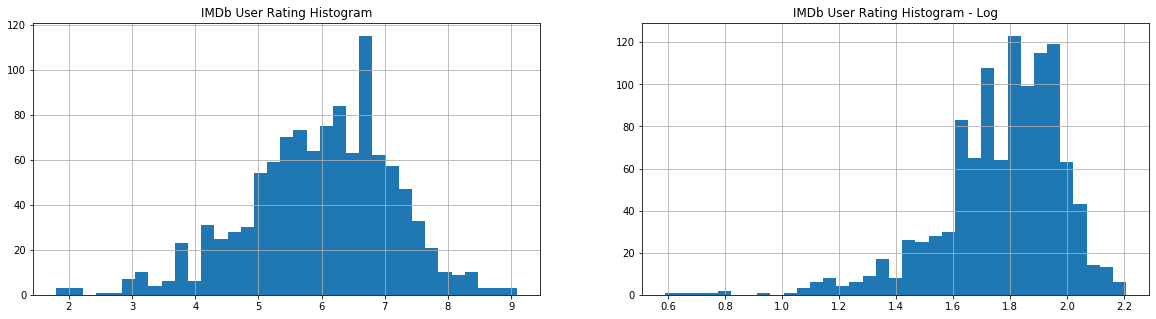

In [35]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("IMDb User Rating Histogram")
model_df['imdb_user_rating'].hist(bins=35)

plt.subplot(122)
plt.title("IMDb User Rating Histogram - Log")
np.log(model_df['imdb_user_rating']).hist(bins=35)

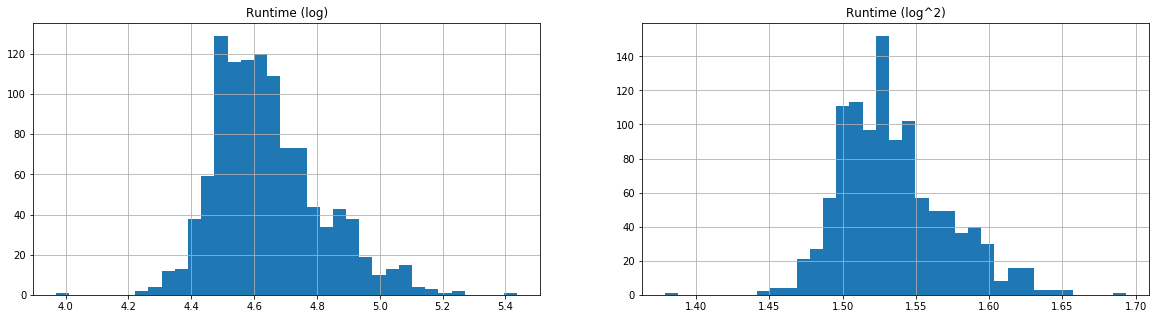

In [36]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Runtime (log)")
model_df['runtime_minutes_log'].hist(bins=35)

plt.subplot(122)
plt.title("Runtime (log^2)")
np.log(model_df['runtime_minutes_log']).hist(bins=35)

/Users/hellojenny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hellojenny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


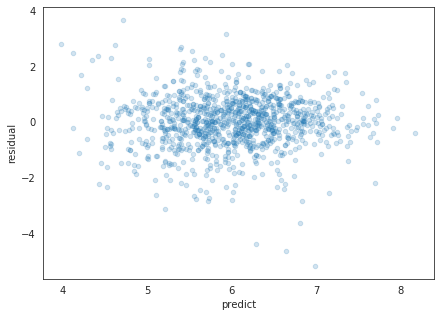

In [37]:
x = model_df.loc[:, features]
y = model_df['imdb_user_rating']

lr = LinearRegression()
fit = lr.fit(x, y)
model_df['predict'] = fit.predict(x)
model_df['residual'] = model_df['imdb_user_rating'] - model_df['predict']

with sns.axes_style('white'):
    plot = model_df.plot(kind = 'scatter', 
                         x = 'predict', 
                         y = 'residual', 
                         alpha = 0.2,
                         figsize = (7, 5))


In [38]:
lr.coef_

array([ 0.16740772,  2.26665141,  0.32736032, -0.4887041 , -0.24622159,
       -0.45223345])

### Assumption #3: Residuals are uncorrelated across observations

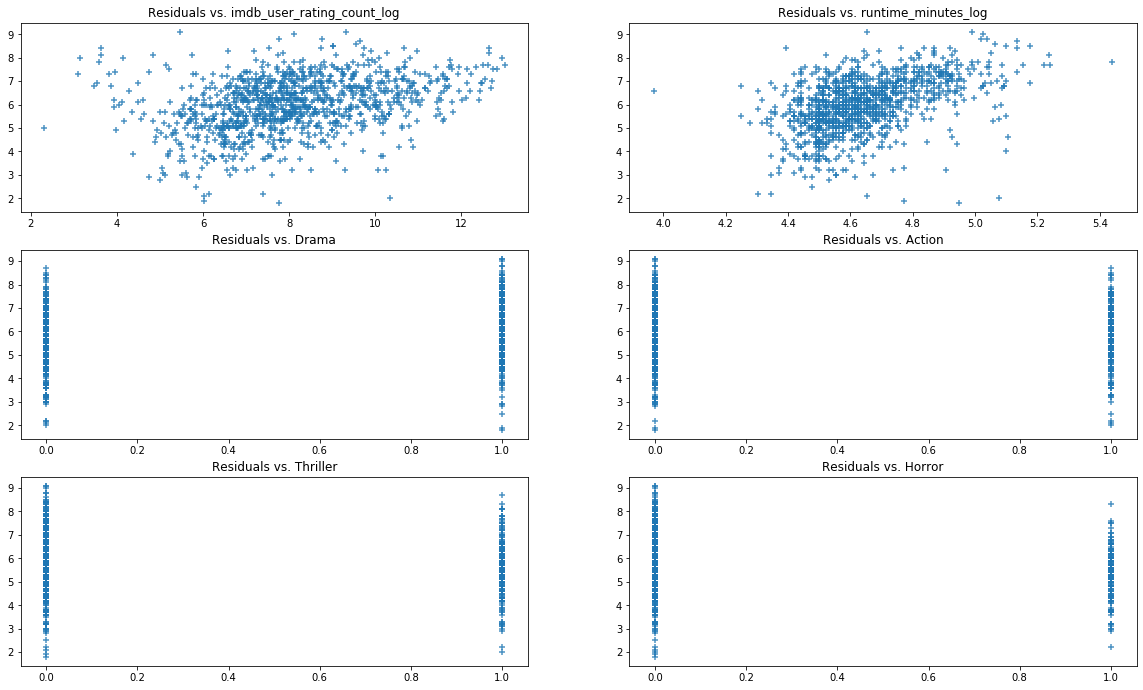

In [39]:
total_num_plots = len(features)
num_rows = int(total_num_plots/2)+1
subplots_width = num_rows*4

plt.figure(figsize=(20,subplots_width))

for plot_num in range(total_num_plots):
    plt.subplot(num_rows, 2, plot_num+1)
    plt.scatter(model_df[features[plot_num]],
                model_df[target],
                marker = "+", 
                alpha = 0.8)
    plt.title("Residuals vs. " + features[plot_num]);

### Assumption #4: No independent variable is a perfect linear function of any other independent variable (no perfect multi-collinearity)
Ways to diagnose: 
1. Inspect correlations of independent features
2. Inspect condition number via `statsmodels` 

Ways to fix:
1. Consider Partial Least Squares or projection into latent space (PCA, introduced in the second-half of the course)
2. Incorporate [Ridge regularization](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) (if it exists, still safe to use if it doesn't)

In [40]:
features = ['imdb_user_rating_count_log',
            'runtime_minutes_log',
           
            # genre
            'Drama',
            'Action',
            'Thriller',
            'Horror',
           ]

target = 'imdb_user_rating'

columns = ['imdb_user_rating', 
           'imdb_user_rating_count_log',
           'runtime_minutes_log',
           
            # genre
            'Drama',
            'Action',
            'Thriller',
            'Horror',
           ]

model_df = imdb_df[columns]

In [41]:
model_df.corr()

,imdb_user_rating,imdb_user_rating_count_log,runtime_minutes_log,Drama,Action,Thriller,Horror
imdb_user_rating,1.000000,0.329963,0.457718,0.303143,-0.084152,-0.175430,-0.245420
imdb_user_rating_count_log,0.329963,1.000000,0.329588,-0.001215,0.210926,-0.008554,0.004775
runtime_minutes_log,0.457718,0.329588,1.000000,0.212804,0.157888,-0.086650,-0.213013
Drama,0.303143,-0.001215,0.212804,1.000000,-0.226472,-0.221971,-0.256066
Action,-0.084152,0.210926,0.157888,-0.226472,1.000000,0.010337,-0.086102
Thriller,-0.175430,-0.008554,-0.086650,-0.221971,0.010337,1.000000,0.182071
Horror,-0.245420,0.004775,-0.213013,-0.256066,-0.086102,0.182071,1.000000


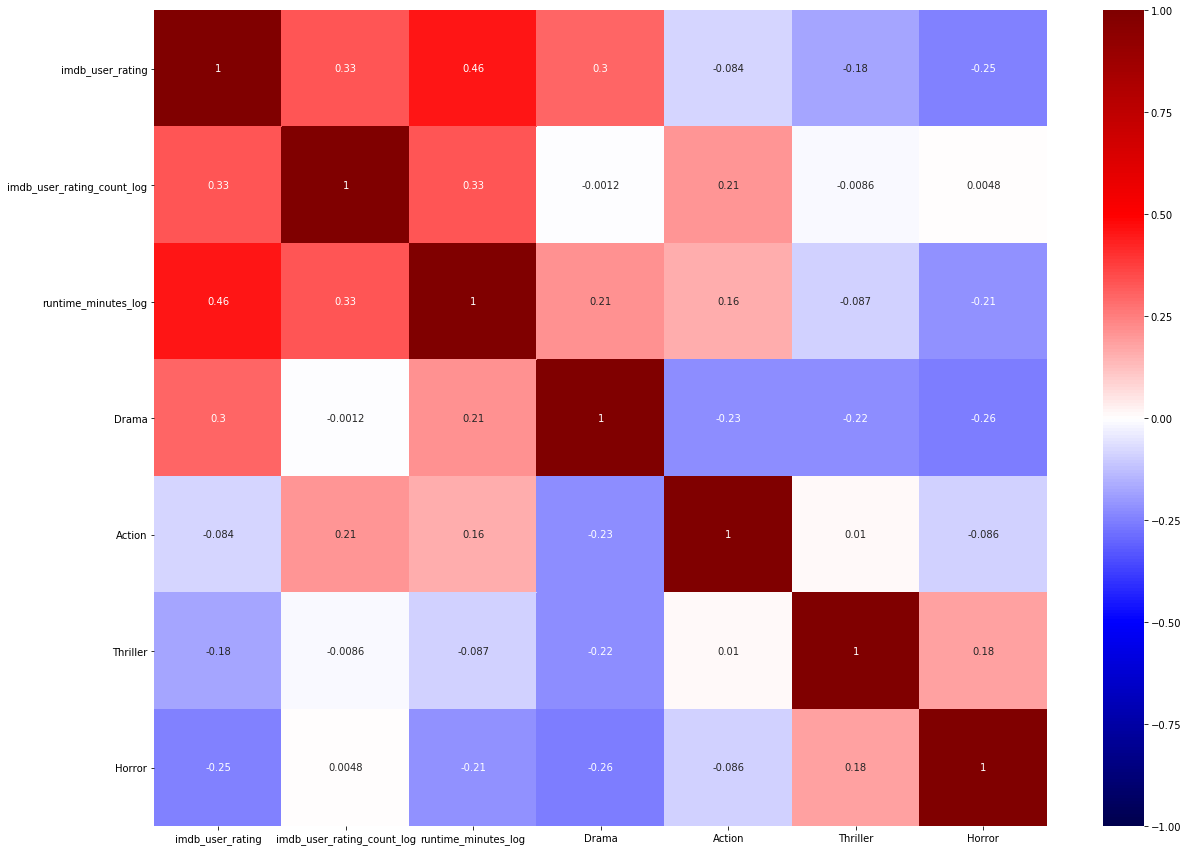

In [42]:
plt.figure(figsize=(20,15))
sns.heatmap(model_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [43]:
#sns.pairplot(model_df, height=2.3, aspect=1.5);

### Assumption #5: Regression is linear in parameters and correctly specified
#### Diagnose:
- **Regression fit:** Inspect plot of observed data vs predicted values (points should be symmetric around the line).
- **Residual plot:** Points should be symmetric around y=0 with roughly constant variance. Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic errors whenever it is making unusually large or small predictions.
- **Q-Q plot:** Look for the middle section of dots to be very close to the diagonal red line. Use the chart below as a reference for interpretation.

In [44]:
def diagnostic_plot(x, y, independent):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel(independent)
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    # Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

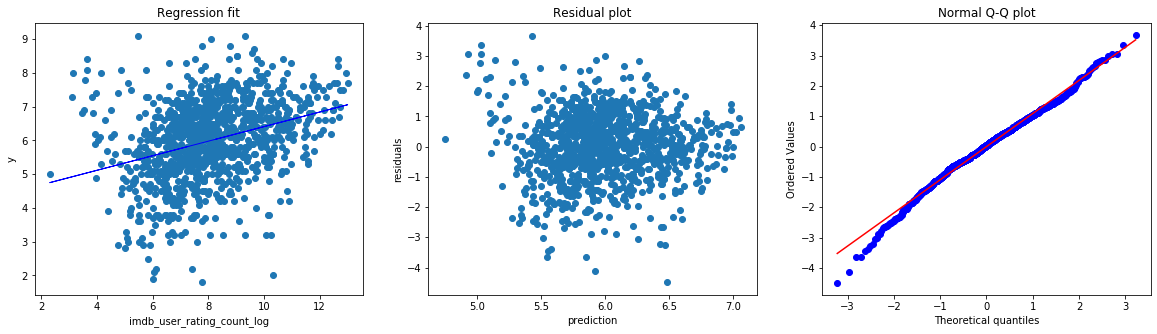

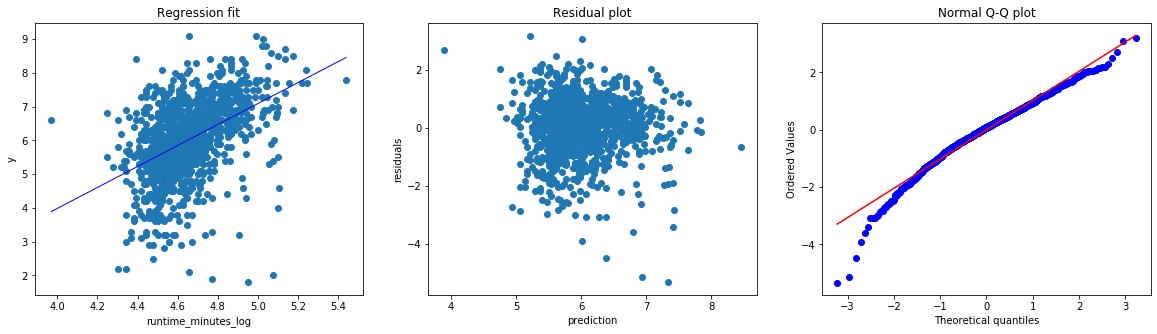

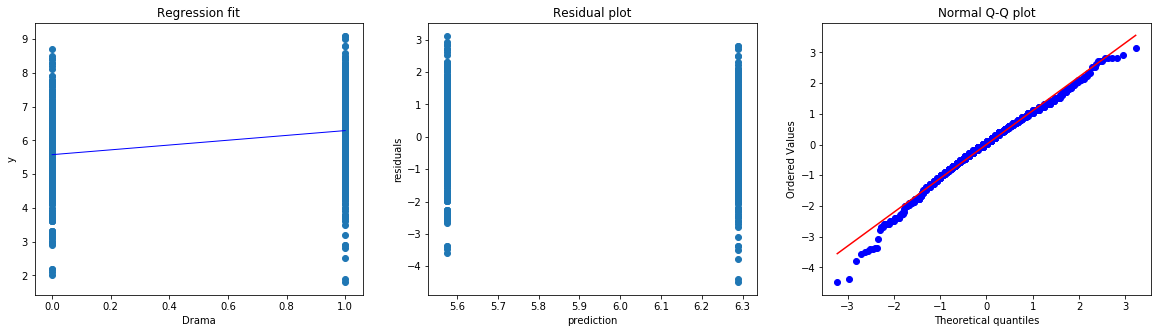

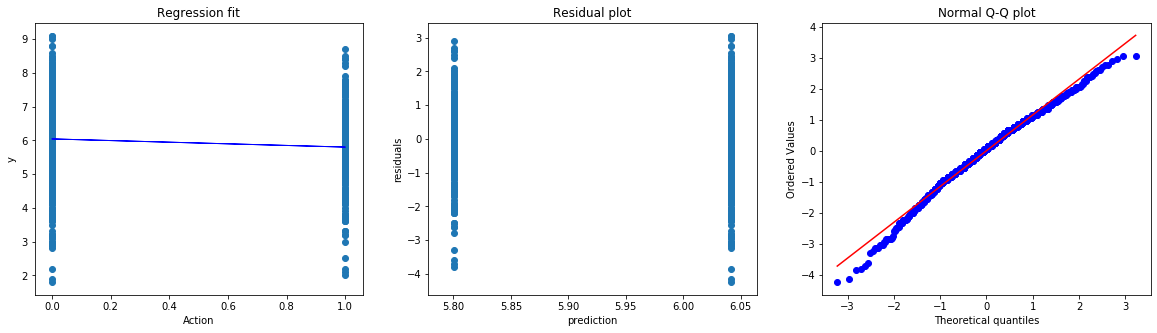

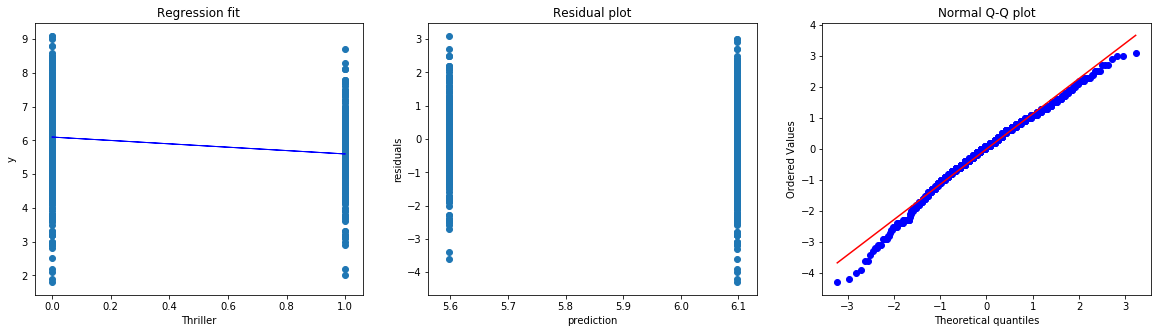

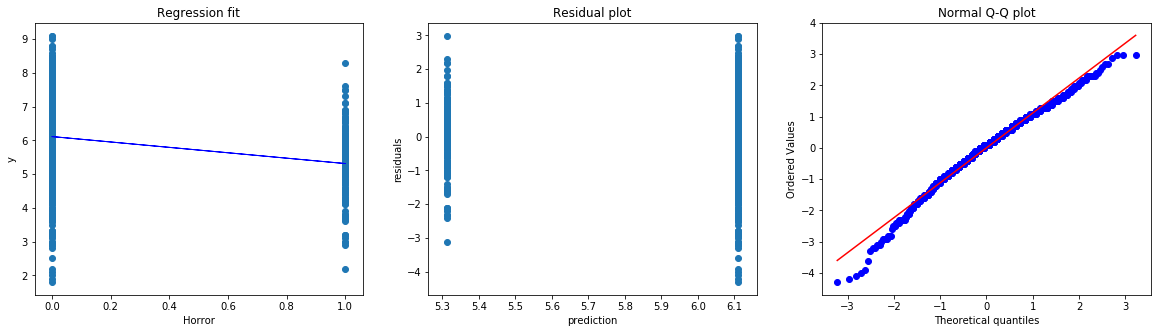

In [45]:
for num in range(len(features)):
    x = model_df[features[num]][:, np.newaxis]
    y = pd.Series(model_df[target])
    diagnostic_plot(x, y, features[num])


In [46]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # make predictions on test data
    y_pred = lr_model.predict(X_test)
    
    # score fit model on validation/test data
    test_score = lr_model.score(X_test, y_test)
    train_score = lr_model.score(X_train, y_train)
    
    # report results
    print('Train-Test_Split R^2 score (test score):', test_score)
    print('Train-Test_Split R^2 score (train score): ', train_score)
    #print('Validation R^2 score: ', metrics.r2_score(y_test, y_pred))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Feature coefficient results:')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(" + ", feature, ':', f'{coef:.2f}') 
        

In [47]:
X = imdb_df.loc[:, features]
y = imdb_df[target]

split_and_validate(X, y)

Train-Test_Split R^2 score (test score): 0.37260024806987646
Train-Test_Split R^2 score (train score):  0.3347146753191089
Mean Absolute Error: 0.6884013524723304
Mean Squared Error: 0.8759681007610571
Root Mean Squared Error: 0.9359316752632412
Feature coefficient results:
 +  imdb_user_rating_count_log : 0.16
 +  runtime_minutes_log : 2.27
 +  Drama : 0.32
 +  Action : -0.50
 +  Thriller : -0.25
 +  Horror : -0.41


# Polynomial Regression

In [48]:
import operator
from sklearn.preprocessing import PolynomialFeatures

def polynomial_transformation(x, y, degree_num, x_label, y_label, title):
    polynomial_features = PolynomialFeatures(degree = degree_num)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    rmse = np.sqrt(metrics.mean_squared_error(y, y_poly_pred))
    r2 = metrics.r2_score(y, y_poly_pred)

    plt.scatter(x, y, label = "data")
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, color='m', label='degree=%d' % degree_num)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='lower right',frameon=True)
    plt.show();

    

It doesn't seem like any of the variable would benefit from polynomial transformation (even before applying log transformation), which is happening later.

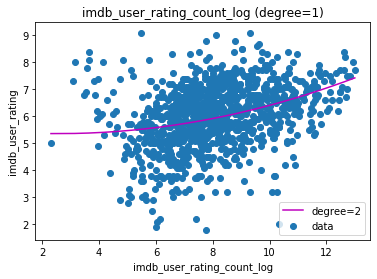

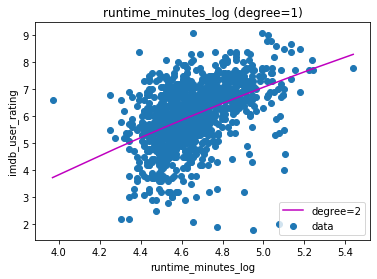

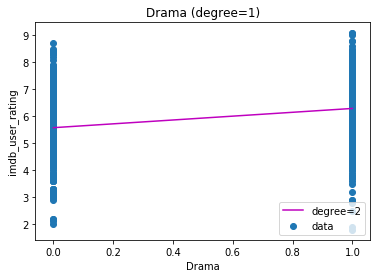

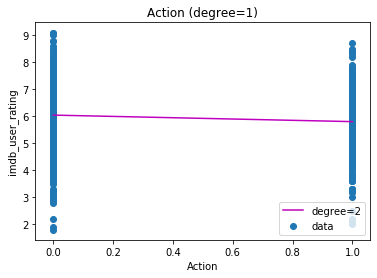

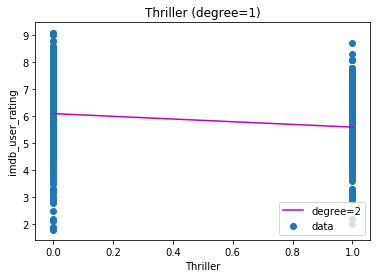

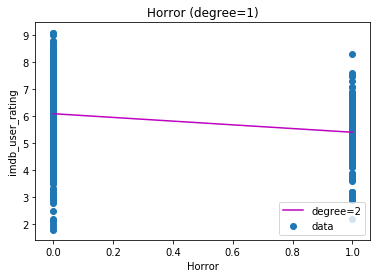

In [49]:
degree_num = 1
for plot_num in range(total_num_plots):
    x = model_df[features[plot_num]][:, np.newaxis]
    y = pd.Series(model_df[target])
    polynomial_transformation(x, y, 2, features[plot_num], target,
                              features[plot_num] + ' (degree=%d)' % degree_num)


# Back to feature engineering

## `imdb_user_rating_count`

Performing log transformation on `imdb_user_rating_count` returns the best R^2. Hence, we use `imdb_user_rating_count_log` in the model.

### 1) No transformation

R^: 0.056778369400528494
P Values:  1.4166770485064878e-15


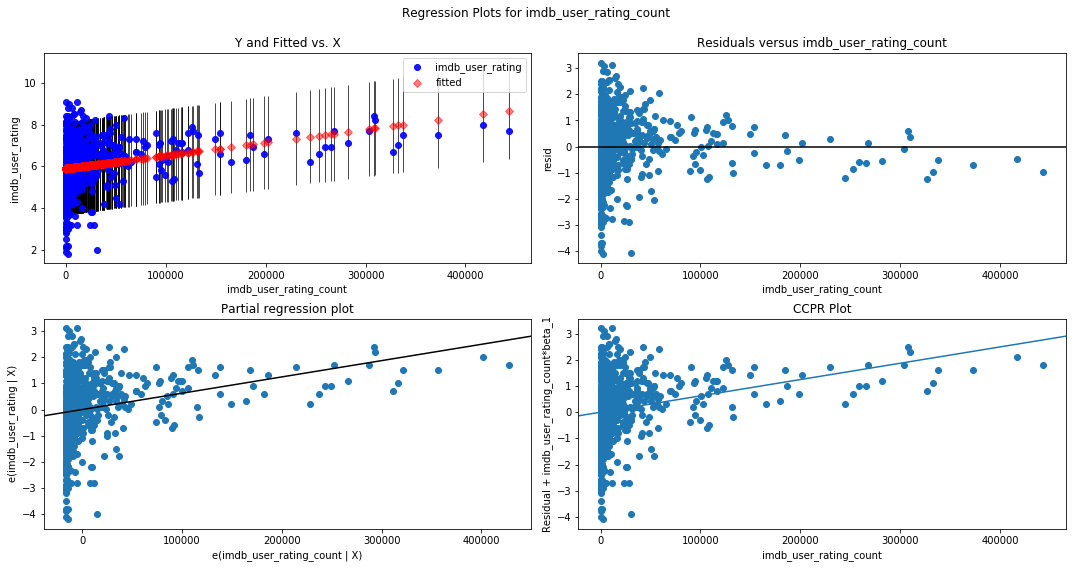

In [50]:
f = 'imdb_user_rating~imdb_user_rating_count'
model = smf.ols(formula=f, data=imdb_df).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'imdb_user_rating_count', fig=fig)

print("R^:", model.rsquared)
print("P Values: ", model.pvalues[1])

### 2) Log

R^: 0.10887527618068638
P Values: 
 3.57040916051766e-29


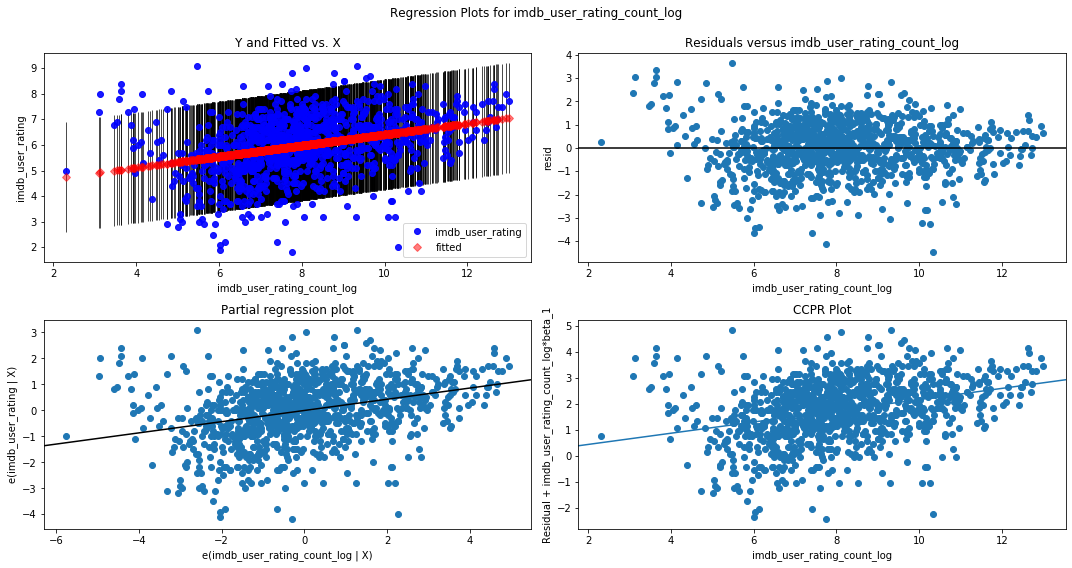

In [62]:
f = 'imdb_user_rating~imdb_user_rating_count_log'
model = smf.ols(formula=f, data=imdb_df).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'imdb_user_rating_count_log', fig=fig)

print("R^:", model.rsquared)
print("P Values: \n", model.pvalues[1])

### 3) Squared

R^: 0.03056436722167466
P Values:  5.95146856408436e-09


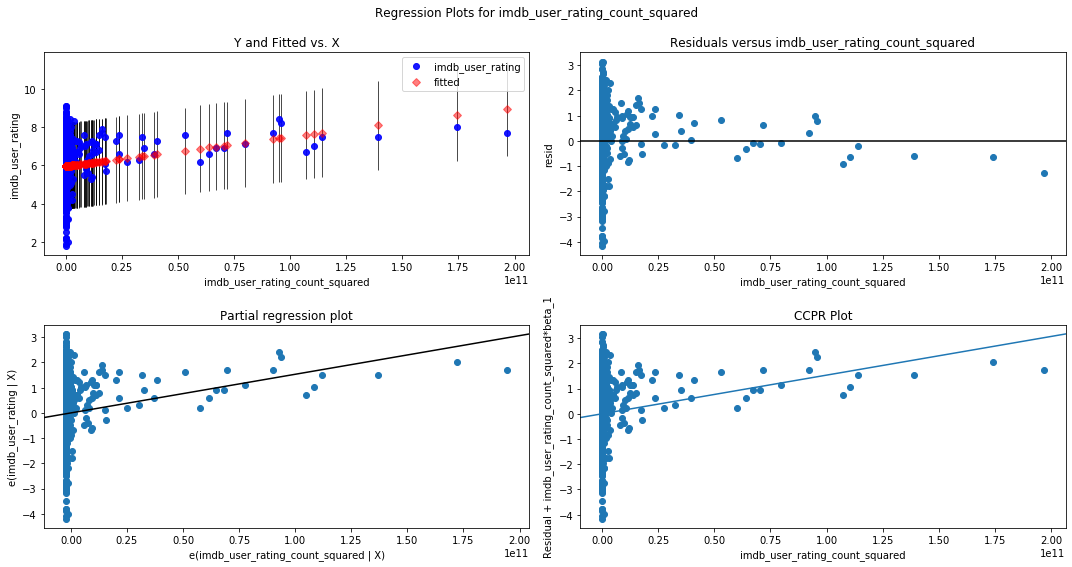

In [52]:
f = 'imdb_user_rating~imdb_user_rating_count_squared'
model = smf.ols(formula=f, data=imdb_df).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, fig=fig,
                                    'imdb_user_rating_count_squared')

print("R^:", model.rsquared)
print("P Values: ", model.pvalues[1])

## `runtime_minutes`

Performing log transformation on `runtime_minutes` returns the best R^2. Hence, we use `runtime_minutes_log` in the model.

### 1) No transformation

R^: 0.20320616458743113
P Values:  8.159048972987376e-56


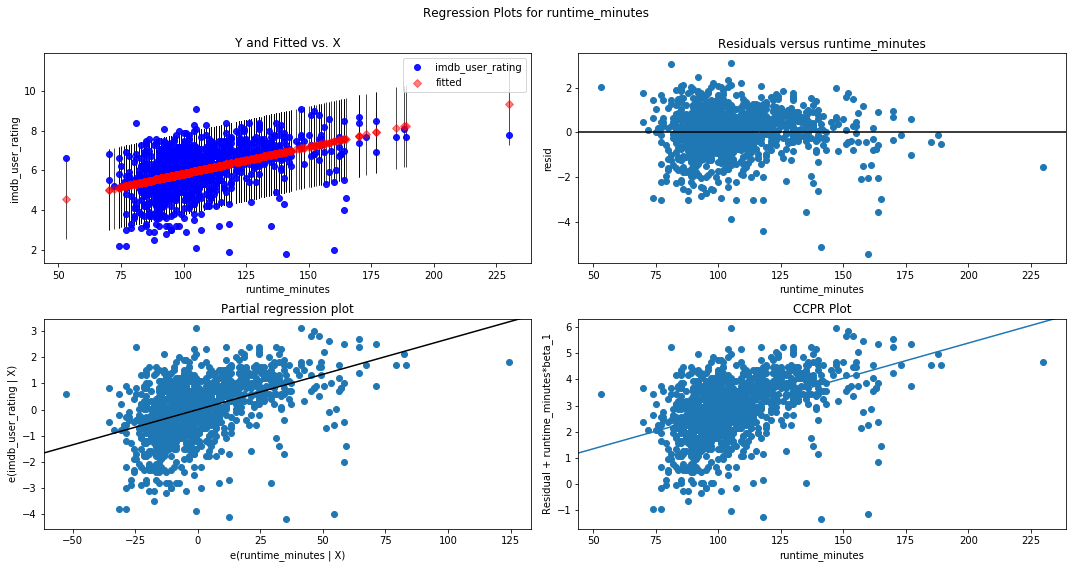

In [53]:
f = 'imdb_user_rating~runtime_minutes'
model = smf.ols(formula=f, data=imdb_df).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'runtime_minutes', fig=fig)

print("R^:", model.rsquared)
print("P Values: ", model.pvalues[1])


### 2) Log

R^: 0.20950556641984308
P Values:  1.0583956424952848e-57


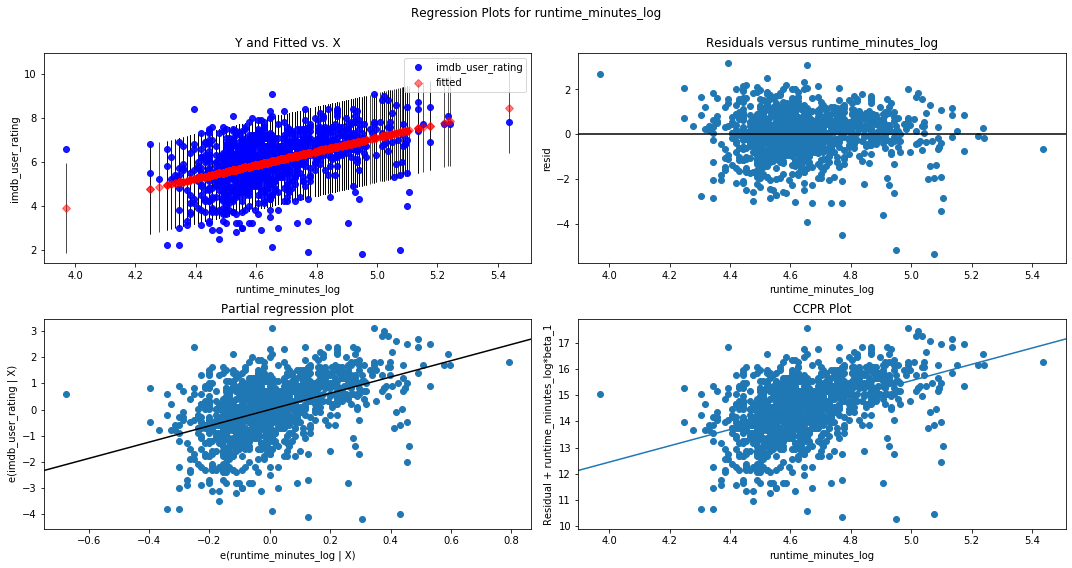

In [54]:
f = 'imdb_user_rating~runtime_minutes_log'
model = smf.ols(formula=f, data=imdb_df).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'runtime_minutes_log', fig=fig)

print("R^:", model.rsquared)
print("P Values: ", model.pvalues[1])

### 3) Squared

R^: 0.18739578185361394
P Values:  3.8359768679628285e-51


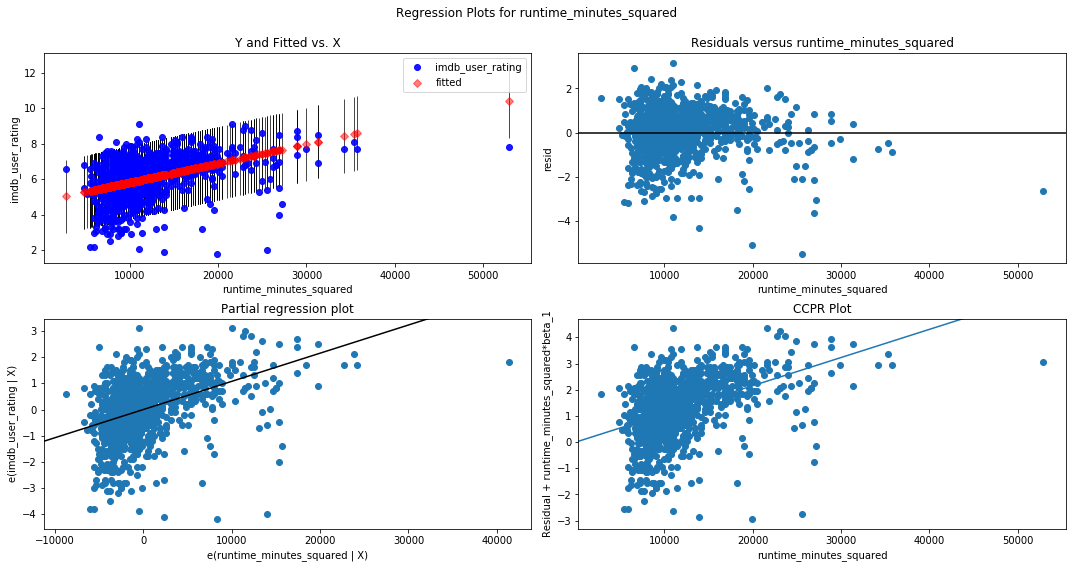

In [55]:
f = 'imdb_user_rating~runtime_minutes_squared'
model = smf.ols(formula=f, data=imdb_df).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'runtime_minutes_squared', fig=fig)

print("R^:", model.rsquared)
print("P Values: ", model.pvalues[1])

# Save the data used for the model in csv file!

In [56]:
imdb_df.to_csv(r"final_imdb_data.csv", index = False)
model_df.to_csv(r"final_model_data.csv", index = False)

In [57]:
## Note that the below helper function came 
## from https://github.com/kevinchiv/Predicting-Altmetric-Score/blob/master/03%20-%20Regression%20Modeling.ipynb

def interpret_beta_coefs(feature_names, beta_coefs, cat_features, log_features, scales, log_y = False):
    """
        Helper function for interpreting beta coefficients
        
        :param feature_names: list of feature names
        :param beta_coefs: list of beta coefficients
        :param cat_features: list of categorical features
        :param log_features: list of independent variables that were log transformed
        :param scales: list of standard deviations of each feature
        :param log_y: boolean that indicates whether dependent variable was transformed
    """
    
    if len(scales):
        beta_coefs = beta_coefs/scaler.scale_
    
    coef_tuples = list(zip(feature_names, beta_coefs))
    
    for feature_name, beta_coef in coef_tuples:
        if log_y:
            if feature_name in log_features:
                change_in_y = round((((1.01)**beta_coef)-1)*100, 2)
                print('For a 1% increase in ' + feature_name + 
                          ', the dependent variable changes by ' + str(change_in_y) + '%')
            else:
                #categorical
                if feature_name in cat_features:
                    change_in_y = round((np.exp(beta_coef)-1)*100, 2)
                    print('If ' + feature_name + \
                          ' had a value of 1, the dependent variable changes by ' \
                          + str(change_in_y) + '%')
                
                #non-categorical
                else:
                    change_in_y = round((np.exp(beta_coef)-1)*100, 2)
                    print('For a 1 unit increase in ' + feature_name +
                          ', the dependent variable changes by ' + str(change_in_y) + '%')
        
        else:
            if feature_name in log_features:
                change_in_y = round(beta_coef*np.log(1.01), 2)
                print('For a 1% increase in ' + feature_name + 
                      ', the dependent variable changes by ' + str(change_in_y) + ' units')
            
            else:
                #categorical
                if feature_name in cat_features:
                    print('If ' + feature_name + 
                          ' had a value of 1, the dependent variable changes by ' 
                          + str(round(beta_coef), 2) + ' units')
                    
                #non-categorical
                else:
                    print('For a 1 unit increase in ' + feature_name + 
                          ', the dependent variable changes by ' + str(round(beta_coef), 2) + ' units')

In [58]:
log_features = ['imdb_user_rating_count_log','runtime_minutes_log']
cat_features = ['Drama', 'Action', 'Thriller','Horror']

interpret_beta_coefs(features, lr.coef_, cat_features, log_features, scaler.scale_, log_y = True)

For a 1% increase in imdb_user_rating_count_log, the dependent variable changes by 0.09%
For a 1% increase in runtime_minutes_log, the dependent variable changes by 14.12%
If Drama had a value of 1, the dependent variable changes by 94.75%
If Action had a value of 1, the dependent variable changes by -70.28%
If Thriller had a value of 1, the dependent variable changes by -45.6%
If Horror had a value of 1, the dependent variable changes by -72.17%
